In [51]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EOS: HH Load Scheduling Data Preparation

This notebook takes you through the preparation of the data for the analysis of EnergyOS. The EnergyOS platform allows different apps to communicate and share information, as well as resource control. This allows the ability to do joint optimizations and achieve better performance in Energy Management Systems.

In this example, we take a look at household load scheduling, in which EnergyOS allows the household to save on energy costs by taking advantage of this connected infrastructure. There is a Battery App with access to good forecasts, as well as an EV app with access to bad forecasts. In order to perform the analysis, we need to prepare the data. This is the same data that is used to run the EnergyOS Household Load Scheduling example simulation.

## Real PV data

We need real PV data to be used as the ground truth for the analysis.

This data is taken from a household in Munich, Germany on June 10, 2013.

Text(0, 0.5, 'PV Module Output [kW]')

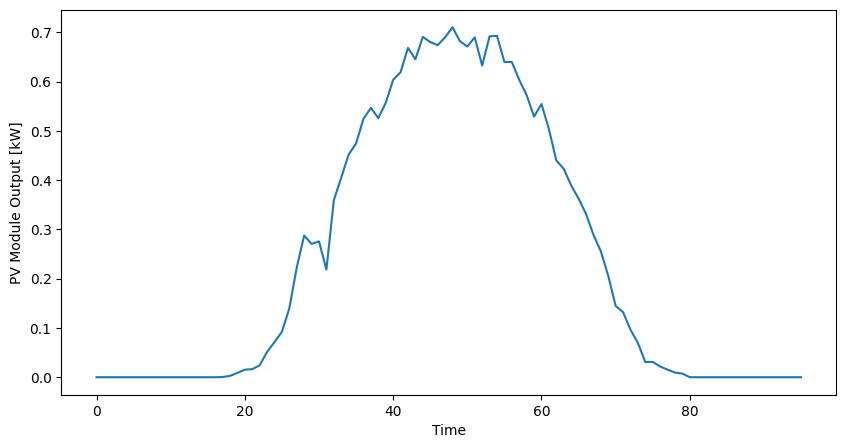

In [52]:
muc_solar_data = pd.read_csv('input/solar_muc_2013-06-10.csv', index_col=0)
muc_solar_data['kW'].plot(figsize=(10,5))
plt.xlabel('Time')
plt.ylabel('PV Module Output [kW]')

## Real Load data

Similarly, we need real load data to be used as the ground truth for the analysis.

This data is also taken from a household in Munich, Germany on June 10, 2013.

Text(0, 0.5, 'HH Load [kW]')

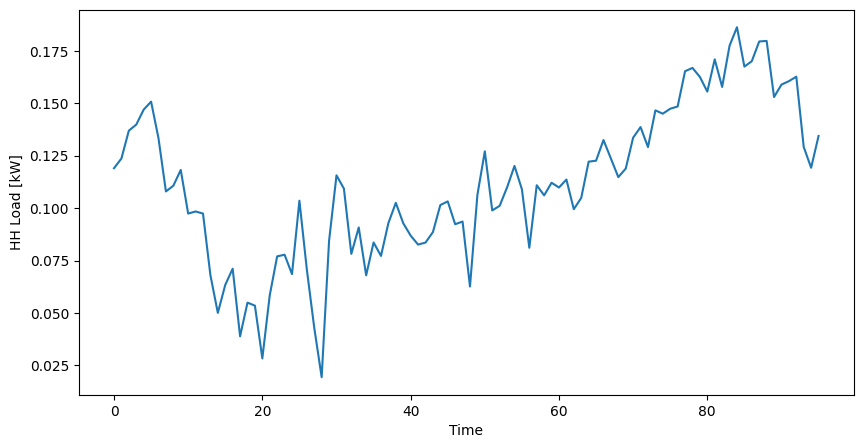

In [53]:
muc_hh_load_data = pd.read_csv('input/hh_load_muc_2013-06-10.csv', index_col=0)
muc_hh_load_data['kW'].plot(figsize=(10,5))
plt.xlabel('Time')
plt.ylabel('HH Load [kW]')

## Noisy Data for "forecasts"

We can create noisy data with a pre-determined accuracy in order to create 'forecasts' with a particular error.

The following function does just that. It prints the relative error, and plots and returns the noisy data.

In [78]:
def create_noisy_data(original_data, sigma_percent=0.1):
    # Plot
    print()
    print('Sigma percent:', sigma_percent)
    noisy_data = original_data.apply(lambda x: np.random.normal(x, sigma_percent*x)).clip(lower=0)
    noisy_data.name = 'power_sigma_' + str(sigma_percent)
    noisy_data.plot(figsize=(10,5))
    plt.xlabel('Timestep')
    plt.ylabel('Power (kW)')
    plt.legend(loc="upper left")
    
    # MAPE
    sum_mape = 0
    N = len(original_data)
    for i in range(0, N):
        orig = original_data.iloc[i]
        noisy = noisy_data.iloc[i]
        if orig == 0:
            continue
        percentage_error = abs(orig - noisy) / orig
        sum_mape += percentage_error
    # MAPE
    mape_error = sum_mape / N
    print('Mean Absolute Percentage Error: {}%'.format(mape_error*100))
    print()
    
    return noisy_data

We use this noise-data-creation function to generate the 'real' (aka perfect), good, and bad forecast variants, for both the solar and load data.


Sigma percent: 0.0
Mean Absolute Percentage Error: 0.0%


Sigma percent: 0.15
Mean Absolute Percentage Error: 7.984128450101968%


Sigma percent: 0.3
Mean Absolute Percentage Error: 14.913537608981153%


Sigma percent: 0.0
Mean Absolute Percentage Error: 0.0%


Sigma percent: 0.02
Mean Absolute Percentage Error: 1.439714901730812%


Sigma percent: 0.07
Mean Absolute Percentage Error: 5.340506631007421%



solar_real (kW)  solar_good (kW)  solar_bad (kW)  load_real (kW)  \
0               0.0              0.0             0.0        0.119021   
1               0.0              0.0             0.0        0.123648   
2               0.0              0.0             0.0        0.136930   
3               0.0              0.0             0.0        0.139794   
4               0.0              0.0             0.0        0.146937   
..              ...              ...             ...             ...   
91              0.0              0.0             0.0        0.160502   
92              0.0              0.0             0.0        0.162659   
93              0.0              0.0             0.0        0.129153   
94              0.0              0.0             0.0        0.119229   
95              0.0              0.0             0.0        0.134386   

    load_good (kW)  load_bad (kW)  
0         0.122029       0.123587  
1         0.120468       0.143961  
2         0.136766       0.140066  
3         0.140682       0.145083  
4         0.149690       0.141875  
..             ...            ...  
91        0.159692       0.153892  
92        0.156303       0.168380  
93        0.131717       0.128447  
94        0.121372       0.117958  
95        0.137435       0.131828  

[96 rows x 6 columns]

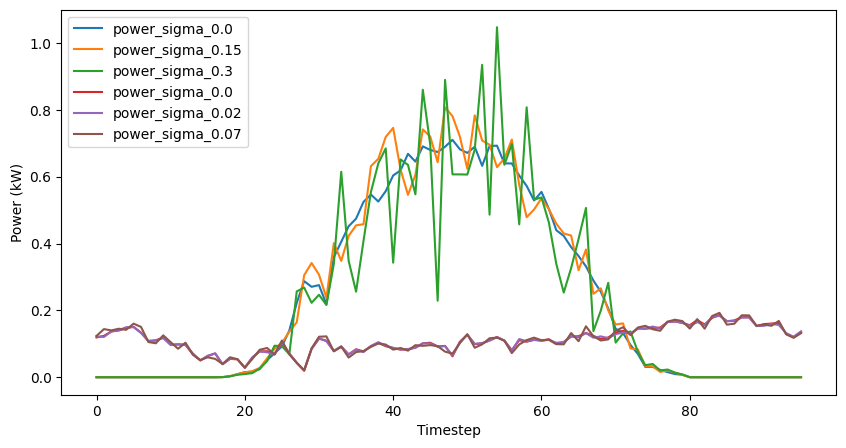

In [82]:
forecasts = pd.DataFrame()

# Add Solar Data
forecasts['solar_real (kW)'] = create_noisy_data(muc_solar_data['kW'], 0.0)
forecasts['solar_good (kW)'] = create_noisy_data(muc_solar_data['kW'], 0.15)
forecasts['solar_bad (kW)'] = create_noisy_data(muc_solar_data['kW'], 0.3)

# Add Load Data
forecasts['load_real (kW)'] = create_noisy_data(muc_hh_load_data['kW'], 0.0)
forecasts['load_good (kW)'] = create_noisy_data(muc_hh_load_data['kW'], 0.02)
forecasts['load_bad (kW)'] = create_noisy_data(muc_hh_load_data['kW'], 0.07)

forecasts

When we are happy with the data, we can also save these forecasts to a file in order to keep the data consistent during analysis.

We do this later with the rest of the data.

## Running OpenTUMFlex simulations

We can then use these forecasts directly as the input data for OpenTUMFlex, in order to get optimal charge schedules.

We will need to replace the existing input data with our desired curves, run the OpenTUMFlex simulation, and save the schedules as output.

The code to read and write the CSV was taken from the `read_data` function of [init_ems.py](https://github.com/tum-ewk/OpenTUMFlex/blob/master/opentumflex/configuration/init_ems.py) from the OpenTUMFlex source code.

In [43]:
def read_OpenTUMFlex_input(input_file='input/input_data.csv'):
    csv_data = pd.read_csv(input_file, sep=';', index_col=0)
    prop = csv_data.iloc[:, 0:2].dropna(how='all')
    ts = csv_data.iloc[:, 2:].dropna(how='all')
    return prop, ts

def write_OpenTUMFlex_input(prop, ts, output_file='output/eos_input_data.csv'):
    pd.concat([prop, ts], sort=False).to_csv(output_file, sep=';')

The original forecast input looks like this:

In [44]:
prop, ts = read_OpenTUMFlex_input(input_file='input/input_data.csv')
ts.head()

temperature  solar_power  load_heat  load_elec  ele_price_in  gas_price  \
0          0.0          0.0   0.001200   0.000533      0.281831   0.074988   
1          0.0          0.0   0.017007   0.516305      0.283655   0.072956   
2          0.0          0.0   0.001200   0.516305      0.285463   0.074012   
3          0.0          0.0   0.055172   0.516305      0.287247   0.070524   
4          0.0          0.0   2.205382   0.726054      0.289000   0.076582   

   ele_price_out  ev_aval  
0           0.11      1.0  
1           0.11      1.0  
2           0.11      1.0  
3           0.11      1.0  
4           0.11      1.0

To make it easier to run these EOS OpenTUMFlex cases, we made a utility script, and a function here that outputs instructions on how to run the command. It utilizes the forecasts above to run certain cases depending on your given params. If combined is False, one of `bat` and `ev` should be `None`. Combined means that the battery is aware of the ev schedule, so this is added to the battery's load prediction.

**Function parameters for `prepare_EOS_sim`**

bat: 'bad', 'good', 'real', None \
ev: 'bad', 'good', 'real', None \
combined: True or False \
ev_load_file: Path to file for the ev load to add for the combined case. \
output_schedule_file: Path to the file you want the OpenTUMFlex output to go to.*
 
*Note: You will need the absolute path to the file, if the relative one is incorrect.

In [45]:
def prepare_EOS_sim(bat, ev, combined, extra_ev_load_file, output_schedule_file):
    assert bat == None or ev == None
    if combined:
        assert bat != None
        assert extra_ev_load_file != None

    input_data_file = 'input/input_data.csv'
    output_data_file = 'output/eos_input_data.csv'
    choices = {
        'bad': (forecasts['solar_bad (kW)'], forecasts['load_bad (kW)']),
        'good': (forecasts['solar_good (kW)'], forecasts['load_good (kW)']),
        'real': (forecasts['solar_real (kW)'], forecasts['load_real (kW)']),
    }
    
    name = 'bat' if bat else 'ev'
    case = bat if bat else ev

    # Put forecasts into input file
    pv, load = choices[case]
    prop, ts = read_OpenTUMFlex_input(input_data_file)
    ts['solar_power'][0:len(pv)] = pv
    ts['load_elec'][0:len(load)] = load
    if combined:
        ev_load = pd.read_csv(extra_ev_load_file, index_col=0)
        ts['load_elec'][0:len(load)] = load + ev_load['EV_power']
    ts['ev_aval'][0:len(pv)] = pd.Series([1.0]*len(pv)) # Make ev always available
    write_OpenTUMFlex_input(prop, ts, output_data_file)

    # Output commands
    command = 'python eos_sim.py -m {name} -i {output_data_file} -o {output_schedule_file}'.format(
        output_data_file=output_data_file, name=name, output_schedule_file=output_schedule_file)
    info = (
        'The forecasts have been added to {output_data_file}. You can use it as follows to run OpenTUMFlex:\n\n'
        '{command}\n'
    ).format(output_data_file=output_data_file, command=command)
    return command, info

Now we setup the cases we are actually interested in, and optionally run the simulator from here. To run the simulator, you need to provide your conda environment name that has OpenTUMFlex as `conda_env`, and set the `run` variable to True.

In [46]:
# Need to do ev cases before Battery cases because Battery depends on EV.
sims = [
    (None, 'bad', False, None, 'output/eos_ev_bad.csv'),
    (None, 'good', False, None, 'output/eos_ev_good.csv'),
    (None, 'real', False, None, 'output/eos_ev_real.csv'),
    ('good', None, False, None, 'output/eos_bat_good.csv'),
    ('good', None, True, 'output/eos_ev_good.csv', 'output/eos_bat_good_combined.csv'),
    ('real', None, True, 'output/eos_ev_real.csv', 'output/eos_bat_real_combined.csv'),
]

run = True
conda_env = 'flex-scheduler'
for bat, ev, combined, extra_ev_load_file, output in sims:
    cmd, info = prepare_EOS_sim(bat, ev, combined, extra_ev_load_file, output)
    if run:
        final_cmd = 'conda run -n {env} {cmd}'.format(env=conda_env, cmd=cmd)
        subprocess.run(final_cmd, shell=True)
    else:
        print(info)

/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_neg][i] = ev_flex_temp[p_neg].iat[i] * t_neg_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_pos][i] = ev_flex_temp[p_pos].iat[i] * t_pos_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_neg][i] = ev_flex_temp[p_neg].iat[i] * t_neg_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_pos][i] = ev_flex_temp[p_pos].iat[i] * t_pos_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_neg][i] = ev_flex_temp[p_neg].iat[i] * t_neg_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:98: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ev_flex_temp[e_pos][i] = ev_flex_temp[p_pos].iat[i] * t_pos_flex_avail
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_ev.py:97: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.124861965643641' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.12486196564364' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.03121549141091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.ilo

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.124861965643649' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.12486196564365' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-3.0312154914109124' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.i

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.119021000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.119021000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.089265750000003' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.i

This model is feasible and there is an optimal

This model is feasible and there is an optimal



/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.119021' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 0] = dat1.iloc[i, 2]  - dat1.iloc[i, 1]
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:62: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-12.119021' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 1] = -1*nflex_P
/home/eokoyomon/code/OpenTUMFlex/opentumflex/flexibility/flex_bat.py:63: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-9.08926575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Bat_flex.iloc[i, 3] = Bat_flex.iloc

## Moving the data to EnergyOS

Now that we have prepared all the data, we want to move all the relevant data for EnergyOS to specific files.

Only do this if you want to override the current data. You will need to change override to True.

#### Forecasts
We start with the forecast data we generated earlier.

In [83]:
OVERRIDE = False
base_dir = 'data/' if OVERRIDE else 'test_data/'

In [47]:
forecasts.to_csv(base_dir + 'eos_forecasts.csv')

#### Price

Next we do the Price. We take this from the OpenTUMFlex data that we looked at earlier.

In [48]:
prop, ts = read_OpenTUMFlex_input(input_file='input/input_data.csv')
prices = pd.DataFrame()
prices['import_price (€/kWh)'] = ts['ele_price_in'][0:len(forecasts)]
prices['export_price (€/kWh)'] = ts['ele_price_out'][0:len(forecasts)]
prices.to_csv('base_dir' + 'eos_prices.csv')

#### EV Schedule

We take the EV charge schedule from all of our generate simulations above.

In [49]:
ev_real = pd.read_csv('output/eos_ev_real.csv')
ev_good = pd.read_csv('output/eos_ev_good.csv')
ev_bad = pd.read_csv('output/eos_ev_bad.csv')

charge = 'EV_power'

ev_schedule = pd.DataFrame()
ev_schedule['charge_real (kW)'] = ev_real[charge]
ev_schedule['charge_good (kW)'] = ev_good[charge]
ev_schedule['charge_bad (kW)'] = ev_bad[charge]

ev_schedule.to_csv(base_dir + 'eos_ev_schedules.csv')

#### Battery Schedule

And finally, we take the Battery charge and discharge schedule from the simulations as well.

In [50]:
bat_real_combined = pd.read_csv('output/eos_bat_real_combined.csv')
bat_real = pd.read_csv('output/eos_bat_real.csv')
bat_good_combined = pd.read_csv('output/eos_bat_good_combined.csv')
bat_good = pd.read_csv('output/eos_bat_good.csv')

charge = 'bat_input_power'
discharge = 'bat_output_power'

bat_schedule = pd.DataFrame()

bat_schedule['charge_real_with_ev (kW)'] = bat_real_combined[charge]
bat_schedule['discharge_real_with_ev (kW)'] = bat_real_combined[discharge]

bat_schedule['charge_real (kW)'] = bat_real[charge]
bat_schedule['discharge_real (kW)'] = bat_real[discharge]

bat_schedule['charge_good_with_ev (kW)'] = bat_good_combined[charge]
bat_schedule['discharge_good_with_ev (kW)'] = bat_good_combined[discharge]

bat_schedule['charge_good (kW)'] = bat_good[charge]
bat_schedule['discharge_good (kW)'] = bat_good[discharge]


bat_schedule.to_csv(base_dir + 'eos_bat_schedules.csv')

## Analysis

Now we can analyze the different scenarios. We do this in a separate notebook.

The main data should now be in if you set `OVERRIDE` to True.

```
data/eos_forecasts.csv
data/eos_prices.csv
data/eos_ev_schedules.csv
data/eos_bat_schedules.csv
```